In [1]:
import torch
from torch_geometric.data import Data, DataLoader
from cnf import BipartiteData
from loss import SimpleLossCompute, SimpleLossCompute2, push_to_side
import time
import numpy as np
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/Users/yangzhiping/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
edge_index_pos = torch.tensor([
    [0, 0, 1, 1],
    [0, 1, 1, 2],
])
edge_index_neg = torch.tensor([
    [0, 0, 1, 1],
    [0, 2, 0, 2],
])
x_s = torch.randn(2, 16)  # 2 nodes.
x_t = torch.randn(3, 16)  # 3 nodes.

In [3]:
data = BipartiteData(edge_index_pos, edge_index_neg, x_s, x_t)
data_list = [data, data]
loader = DataLoader(data_list, batch_size=2)
batch = next(iter(loader))

TypeError: full(): argument 'size' must be tuple of ints, but found element of type tuple at pos 1

In [5]:
print(batch)

Batch(edge_index_neg=[2, 8], edge_index_pos=[2, 8], x_s=[4, 16], x_t=[6, 16])


In [6]:
print(batch.edge_index_pos)

tensor([[0, 0, 1, 1, 2, 2, 3, 3],
        [0, 1, 1, 2, 3, 4, 4, 5]])


In [2]:
from data import SATDataset
ds = SATDataset('../dataset', 'RND3SAT/uf50-218', False)
last_trn, last_val = int(len(ds)), int(len(ds))
train_ds = ds[: last_trn]
valid_ds = ds[last_trn: last_val]
test_ds = ds[last_val:]

In [4]:
test_data = train_ds[1]
edge_index_pos = test_data.edge_index_pos
edge_index_neg = test_data.edge_index_neg
variable_count = max(max(edge_index_pos[1]), max(edge_index_neg[1])) + 1
clause_count = len(edge_index_pos[1])

In [5]:
def test_loss(iter_num, par_sm, par_sg, var_num, plot=False):
    loss_func = SimpleLossCompute(par_sm, par_sg, "cuda", debug=True)
    loss_func2 = SimpleLossCompute2(par_sm, par_sg, "cuda", debug=True)
    sat_rate = np.zeros(iter_num)
    loss_v = np.zeros(iter_num)
    loss2_v = np.zeros(iter_num)
    time1 = np.zeros(iter_num)
    time2 = np.zeros(iter_num)
    for i in range(iter_num):
        x_s = push_to_side(torch.rand(var_num, 1), par_sg)
        start = time.time()
        loss, sm = loss_func(x_s, edge_index_pos, edge_index_neg)
        time1[i] = time.time() - start
        satisfied_percentage = sum(sm > 0.5).numpy() / clause_count
        loss_v[i] = loss

        start = time.time()
        loss2, sm2 = loss_func2(x_s, edge_index_pos, edge_index_neg)
        time2[i] = time.time() - start
        loss2_v[i] = loss2
        if sum(sm > 0.5).numpy() / clause_count != satisfied_percentage:
            raise ValueError("Two loss should return same sm")
        sat_rate[i] = satisfied_percentage
    if plot:
        plt.plot(sat_rate, loss_v, "ro")
        plt.xlabel("Satisfied Clauses / Numer of Clauses")
        plt.ylabel("Loss")
    return sat_rate, loss_v, loss2_v, time1, time2

Time for loss1 and loss2 to compute loss of 5000 FG respectively takes 19.197309255599976s


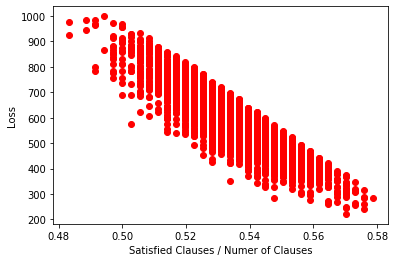

In [14]:
start = time.time()
sat_rate, loss_v, loss2_v, time1, time2 = test_loss(5000, 30, 50, variable_count, True)
span = time.time() - start
print(f"Time for loss1 and loss2 to compute loss of 5000 FG respectively takes {span}s")

In [12]:
ave_time_diff = sum(time1 - time2) / 5000
print(ave_time_diff)
print(min(loss_v))
print(time1[0:10])
print(time2[0:10])

-6.469306945800781e-05
182.59849548339844
[0.00044489 0.00031018 0.00026298 0.00023985 0.00026441 0.000247
 0.00026083 0.000211   0.0002861  0.00020599]
[0.00055289 0.00046062 0.00032711 0.00028086 0.00037503 0.00026965
 0.00029206 0.0002799  0.00031614 0.00029278]
